In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import warnings
from tqdm import tqdm
from datetime import datetime
import json
from sklearn.preprocessing import LabelEncoder
warnings.filterwarnings("ignore")

In [29]:
train = pd.read_csv('../input/tmdb-box-office-prediction/train.csv')
test = pd.read_csv('../input/tmdb-box-office-prediction/test.csv')
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 23 columns):
id                       3000 non-null int64
belongs_to_collection    604 non-null object
budget                   3000 non-null int64
genres                   2993 non-null object
homepage                 946 non-null object
imdb_id                  3000 non-null object
original_language        3000 non-null object
original_title           3000 non-null object
overview                 2992 non-null object
popularity               3000 non-null float64
poster_path              2999 non-null object
production_companies     2844 non-null object
production_countries     2945 non-null object
release_date             3000 non-null object
runtime                  2998 non-null float64
spoken_languages         2980 non-null object
status                   3000 non-null object
tagline                  2403 non-null object
title                    3000 non-null object
Keywords             

In [3]:
train.dtypes

id                         int64
belongs_to_collection     object
budget                     int64
genres                    object
homepage                  object
imdb_id                   object
original_language         object
original_title            object
overview                  object
popularity               float64
poster_path               object
production_companies      object
production_countries      object
release_date              object
runtime                  float64
spoken_languages          object
status                    object
tagline                   object
title                     object
Keywords                  object
cast                      object
crew                      object
revenue                    int64
dtype: object

# **EDA**

In [4]:
train.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


In [5]:
train.describe(include='all')

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
count,3000.000000,604,3.000000e+03,2993,946,3000,3000,3000,2992,3000.000000,2999,2844,2945,3000,2998.000000,2980,3000,2403,3000,2724,2987,2984,3.000000e+03
unique,NaN,422,NaN,872,941,3000,36,2975,2992,NaN,2999,2383,321,2398,NaN,401,2,2400,2969,2648,2975,2984,NaN
top,NaN,"[{'id': 645, 'name': 'James Bond Collection', ...",NaN,"[{'id': 18, 'name': 'Drama'}]",http://www.transformersmovie.com/,tt1214962,en,Fantastic Four,Seven close friends reunite for the wedding of...,NaN,/pfa5A6V7UNXqDi1T9FebJ8hT6Lf.jpg,"[{'name': 'Paramount Pictures', 'id': 4}]","[{'iso_3166_1': 'US', 'name': 'United States o...",9/10/10,NaN,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Based on a true story.,Sahara,"[{'id': 10183, 'name': 'independent film'}]",[],"[{'credit_id': '571ad73ec3a368197c00118f', 'de...",NaN
freq,NaN,16,NaN,266,4,1,2575,2,1,NaN,1,51,1752,5,NaN,1817,2996,3,2,27,13,1,NaN
mean,1500.500000,NaN,2.253133e+07,NaN,NaN,NaN,NaN,NaN,NaN,8.463274,NaN,NaN,NaN,NaN,107.856571,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.672585e+07
std,866.169729,NaN,3.702609e+07,NaN,NaN,NaN,NaN,NaN,NaN,12.104000,NaN,NaN,NaN,NaN,22.086434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.375323e+08
min,1.000000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,0.000001,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000000e+00
25%,750.750000,NaN,0.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,4.018053,NaN,NaN,NaN,NaN,94.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.379808e+06
50%,1500.500000,NaN,8.000000e+06,NaN,NaN,NaN,NaN,NaN,NaN,7.374861,NaN,NaN,NaN,NaN,104.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.680707e+07
75%,2250.250000,NaN,2.900000e+07,NaN,NaN,NaN,NaN,NaN,NaN,10.890983,NaN,NaN,NaN,NaN,118.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.891920e+07


Count of missing values in each column in train:

In [6]:
#Since only last two digits of year are provided, this is the correct way of getting the year.
train[['release_month','release_day','release_year']]=train['release_date'].str.split('/',expand=True).replace(np.nan, -1).astype(int)
# Some rows have 4 digits of year instead of 2, that's why I am applying (train['release_year'] < 100) this condition
train.loc[ (train['release_year'] <= 19) & (train['release_year'] < 100), "release_year"] += 2000
train.loc[ (train['release_year'] > 19)  & (train['release_year'] < 100), "release_year"] += 1900

releaseDate = pd.to_datetime(train['release_date']) 
train['release_dayofweek'] = releaseDate.dt.dayofweek
train['release_quarter'] = releaseDate.dt.quarter

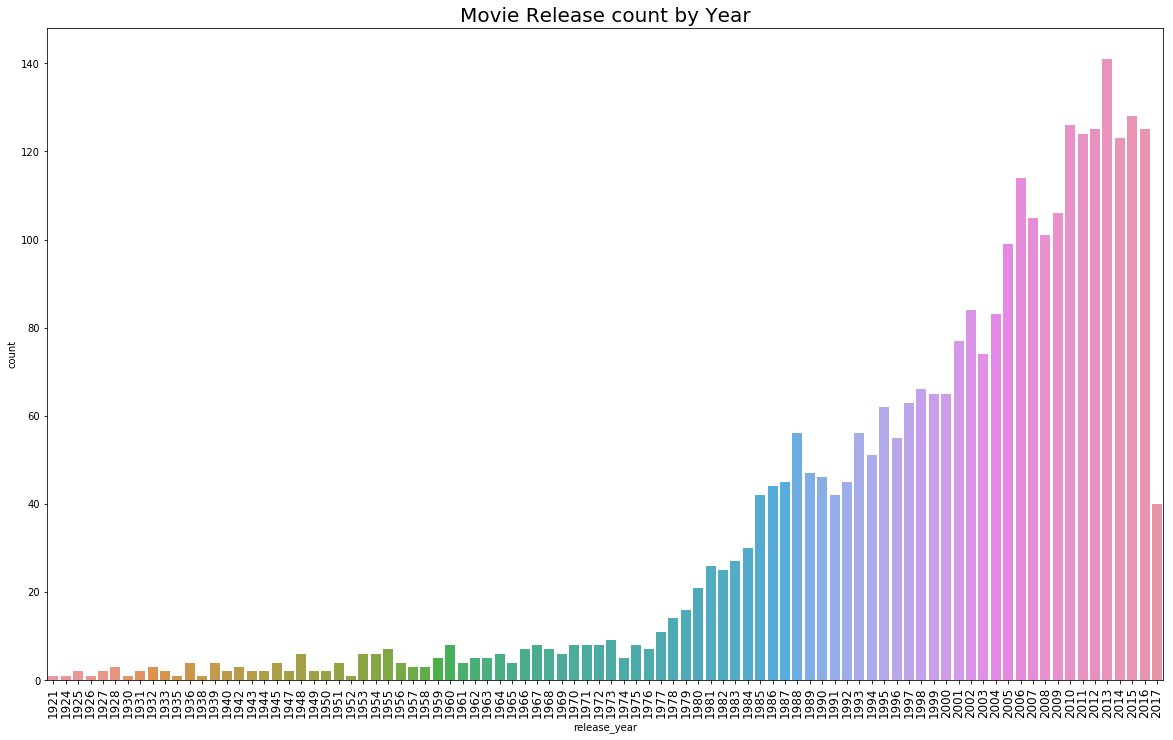

In [7]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_year'].sort_values())
plt.title("Movie Release count by Year",fontsize=20)
loc, labels = plt.xticks()
plt.xticks(fontsize=12,rotation=90)
plt.show()

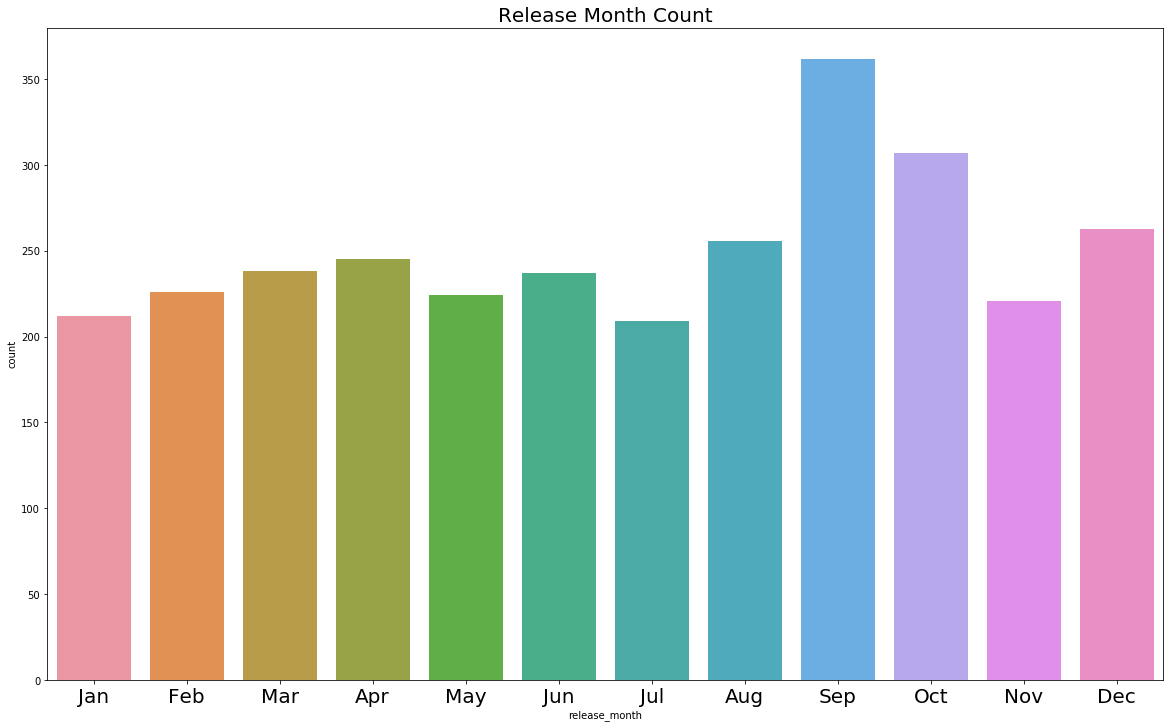

In [8]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_month'].sort_values())
plt.title("Release Month Count",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

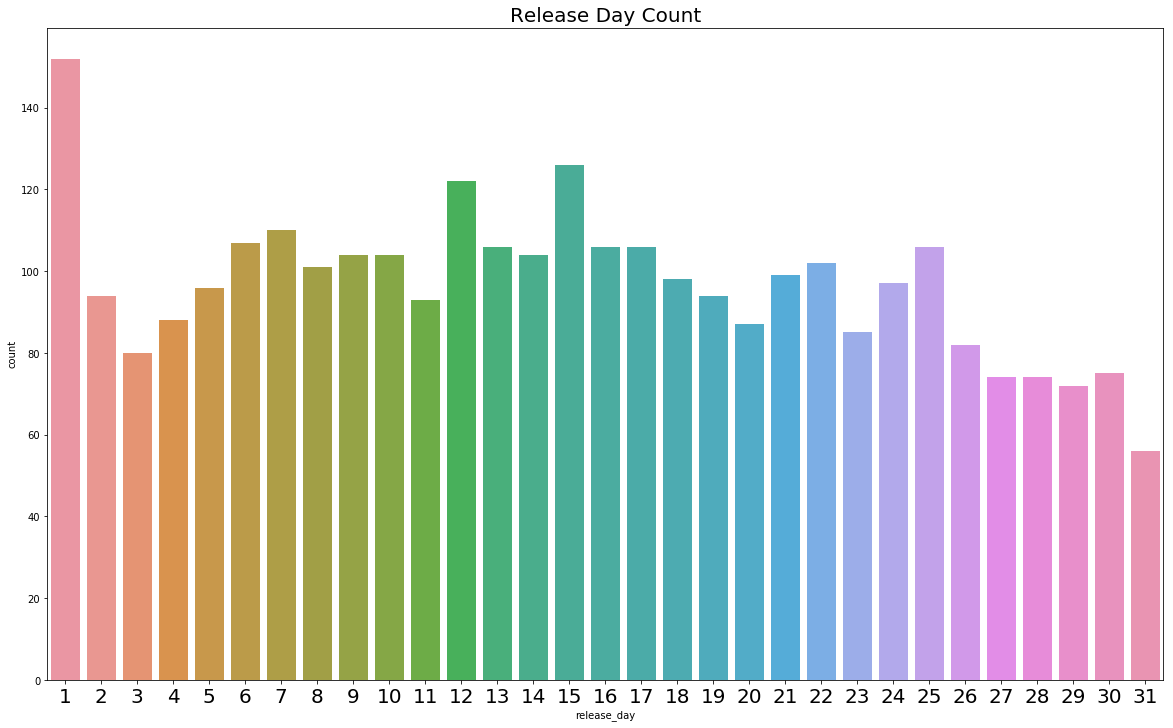

In [9]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_day'].sort_values())
plt.title("Release Day Count",fontsize=20)
plt.xticks(fontsize=20)
plt.show()

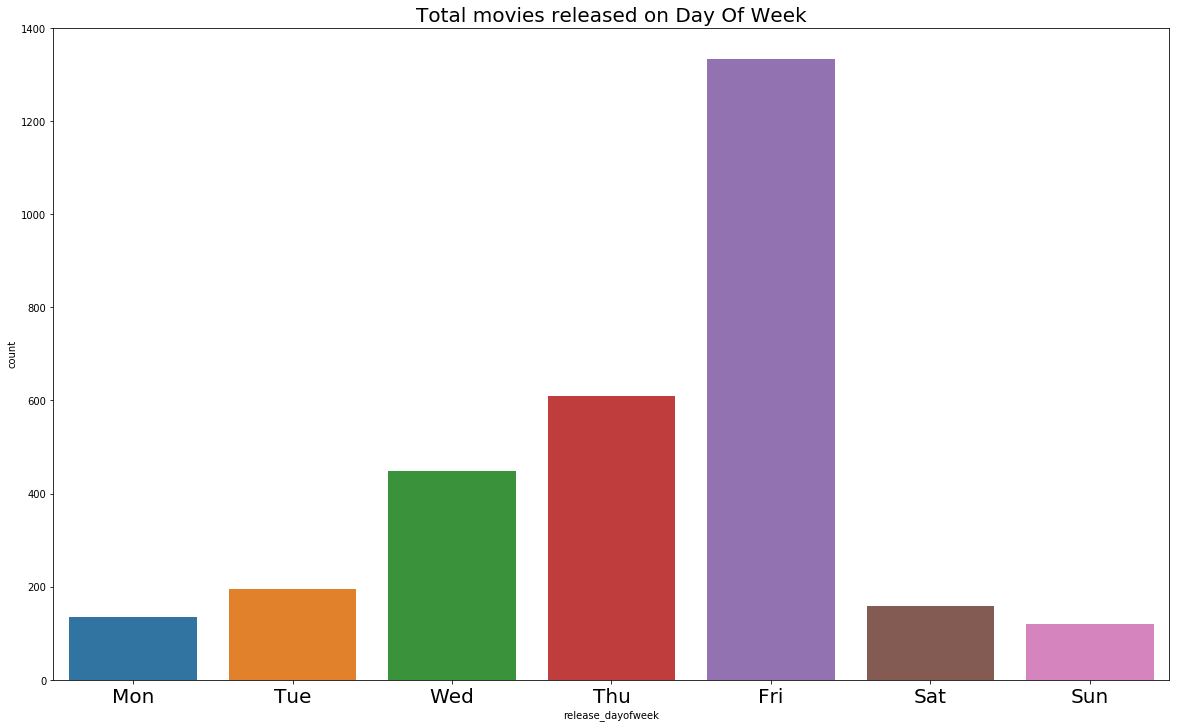

In [10]:
plt.figure(figsize=(20,12))
sns.countplot(train['release_dayofweek'].sort_values())
plt.title("Total movies released on Day Of Week",fontsize=20)
loc, labels = plt.xticks()
loc, labels = loc, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"]
plt.xticks(loc, labels,fontsize=20)
plt.show()

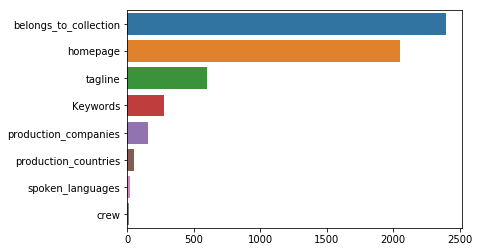

In [11]:
missing=train.isna().sum().sort_values(ascending=False)
sns.barplot(missing[:8],missing[:8].index)
plt.show()

In [12]:
import ast
dict_columns = ['belongs_to_collection', 'genres', 'production_companies',
                'production_countries', 'spoken_languages', 'Keywords', 'cast', 'crew']

def text_to_dict(df):
    for column in dict_columns:
        df[column] = df[column].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x) )
    return df
        
dfx = text_to_dict(train)
for col in dict_columns:
       train[col]=dfx[col]

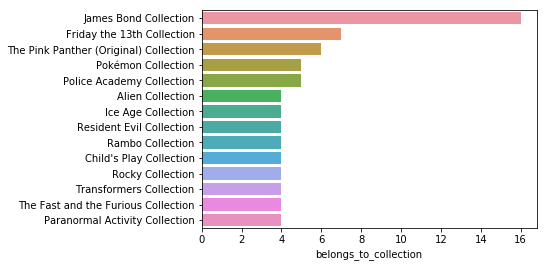

In [14]:
train['belongs_to_collection'].apply(lambda x:len(x) if x!= {} else 0).value_counts()
collections=train['belongs_to_collection'].apply(lambda x : x[0]['name'] if x!= {} else '?').value_counts()[1:15]
sns.barplot(collections,collections.index)
plt.show()

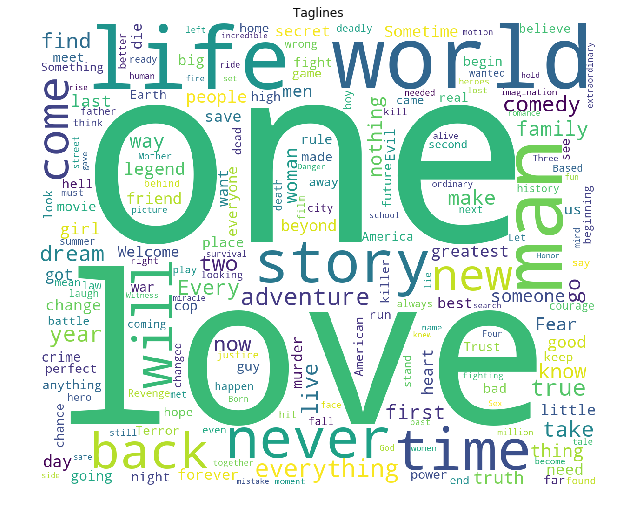

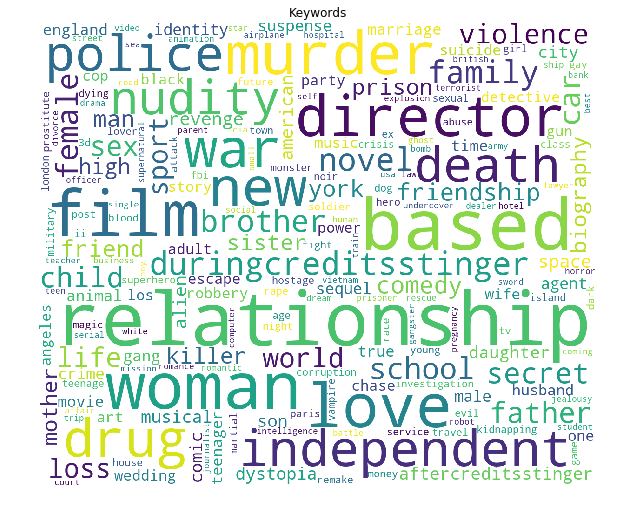

In [17]:
from wordcloud import WordCloud
train['tagline'].apply(lambda x:1 if x is not np.nan else 0).value_counts()
plt.figure(figsize=(10,10))
taglines=' '.join(train['tagline'].apply(lambda x:x if x is not np.nan else ''))
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(taglines)
plt.imshow(wordcloud)
plt.title('Taglines')
plt.axis("off")
plt.show()

keywords=train['Keywords'].apply(lambda x: ' '.join(i['name'] for i in x) if x != {} else '')
plt.figure(figsize=(10,10))
data=' '.join(words for words in keywords)
wordcloud = WordCloud(max_font_size=None, background_color='white', collocations=False,
                      width=1200, height=1000).generate(data)
plt.imshow(wordcloud)
plt.title('Keywords')
plt.axis("off")
plt.show()

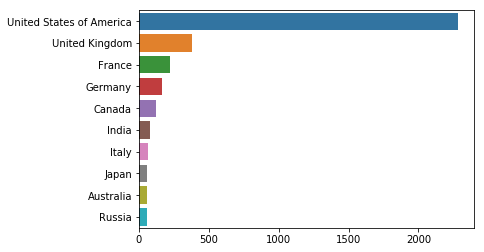

In [20]:
from collections import Counter 
# 20 most common production countries
countries=train['production_countries'].apply(lambda x: [i['name'] for i in x] if x!={} else []).values
count=Counter([j for i in countries for j in i]).most_common(10)
sns.barplot([val[1] for val in count],[val[0] for val in count])

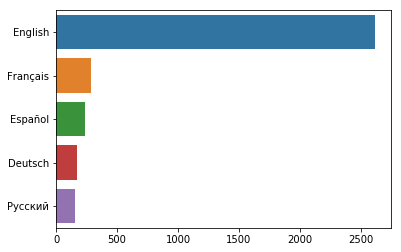

In [21]:
# count of different different languages
train['spoken_languages'].apply(lambda x:len(x) if x !={} else 0).value_counts()
# 5 most common spoken languages
lang=train['spoken_languages'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in lang for i in j]).most_common(5)
sns.barplot([val[1] for val in count],[val[0] for val in count])

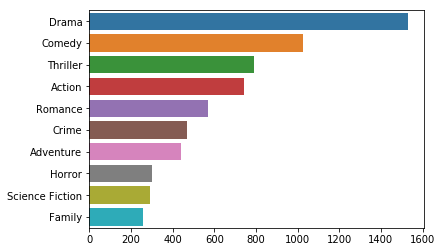

In [22]:
# 10 most common genres
genre=train['genres'].apply(lambda x: [i['name'] for i in x] if x != {} else [])
count=Counter([i for j in genre for i in j]).most_common(10)
sns.barplot([val[1] for val in count],[val[0] for val in count])

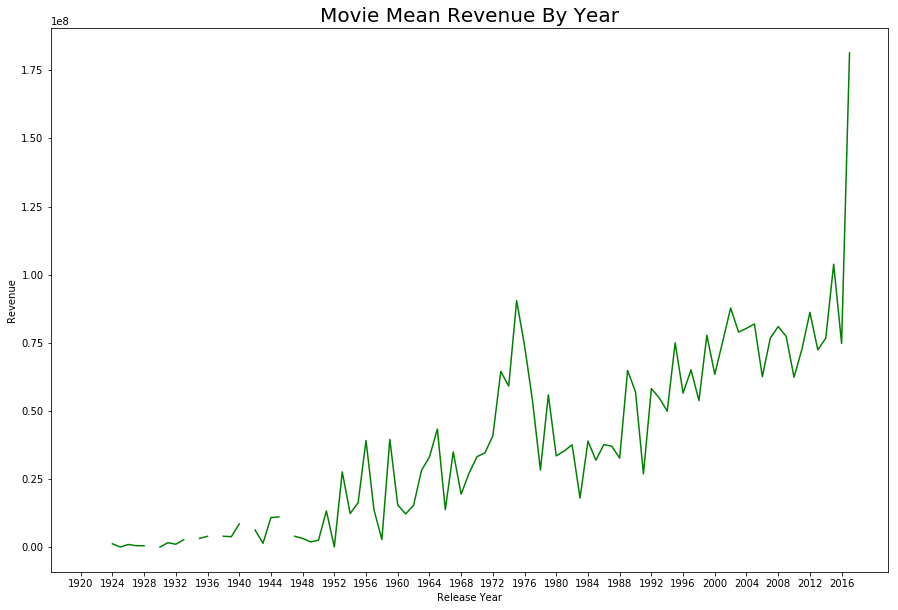

In [23]:
train['meanRevenueByYear'] = train.groupby("release_year")["revenue"].aggregate('mean')
train['meanRevenueByYear'].plot(figsize=(15,10),color="g")
plt.xticks(np.arange(1920,2018,4))
plt.xlabel("Release Year")
plt.ylabel("Revenue")
plt.title("Movie Mean Revenue By Year",fontsize=20)
plt.show()

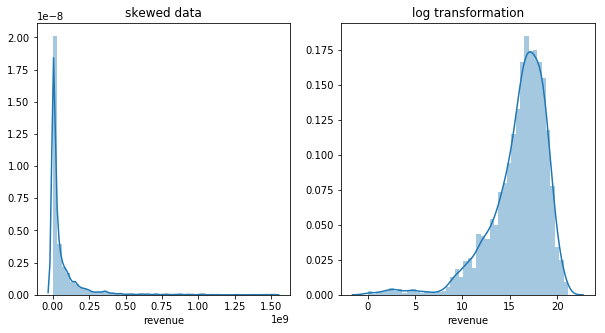

In [24]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title('skewed data')
sns.distplot(train['revenue'])
plt.subplot(1,2,2)
plt.title('log transformation')
sns.distplot(np.log(train['revenue']))
plt.show()

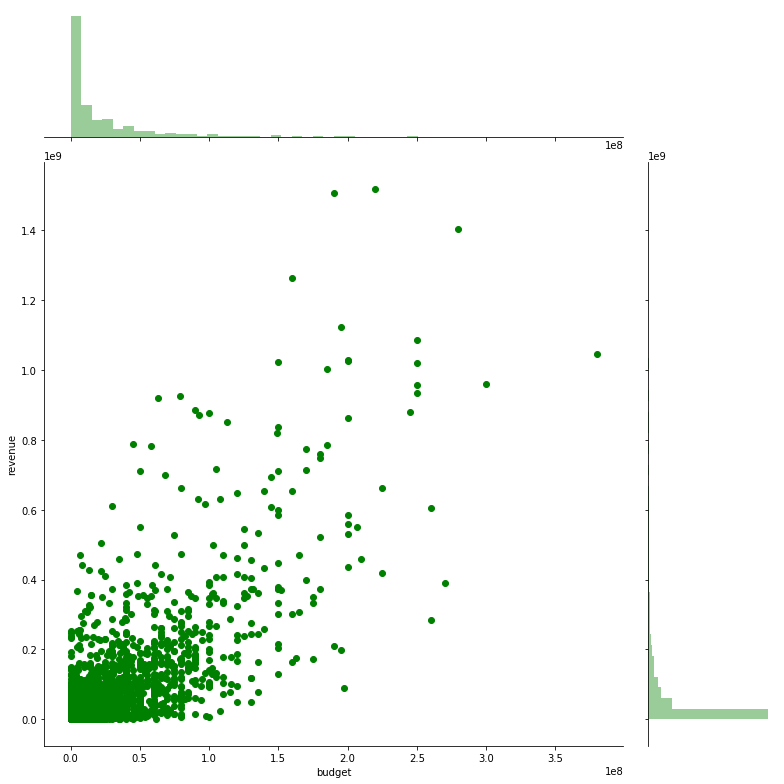

In [25]:
sns.jointplot(x="budget", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

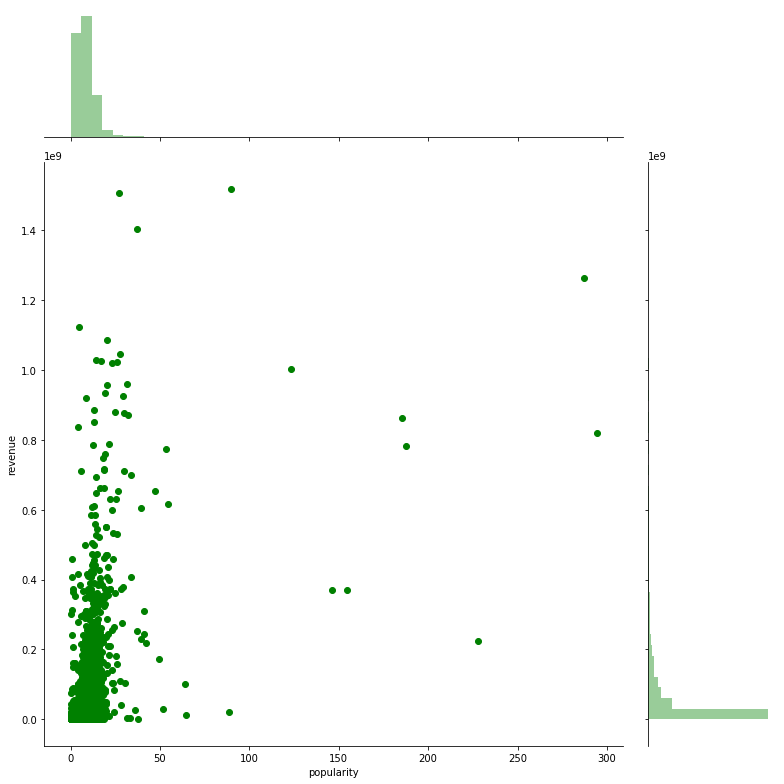

In [26]:
sns.jointplot(x="popularity", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

Plot runtime vs revenue

In [ ]:
sns.jointplot(x="runtime", y="revenue", data=train, height=11, ratio=4, color="g")
plt.show()

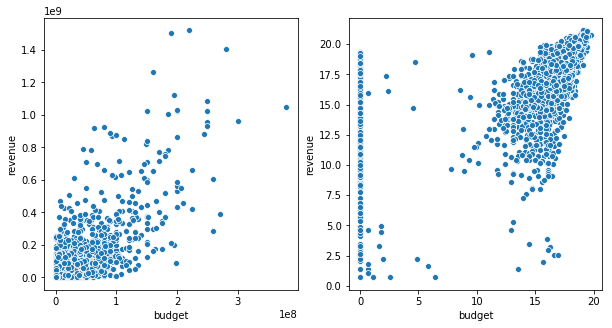

In [27]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
sns.scatterplot(train['budget'],train['revenue'])
plt.subplot(1,2,2)
sns.scatterplot(np.log1p(train['budget']),np.log1p(train['revenue']))
plt.show()

**Feature engineering**

In [28]:
def  prepare_data(df):
    df['_budget_runtime_ratio'] = (df['budget']/df['runtime']).replace([np.inf,-np.inf,np.nan],0)
    df['_budget_popularity_ratio'] = df['budget']/df['popularity']
    df['_budget_year_ratio'] = df['budget'].fillna(0)/(df['release_year']*df['release_year'])
    df['_releaseYear_popularity_ratio'] = df['release_year']/df['popularity']
    df['_releaseYear_popularity_ratio2'] = df['popularity']/df['release_year']
    df['budget']=np.log1p(df['budget'])
    
    df['collection_name']=df['belongs_to_collection'].apply(lambda x: x[0]['name'] if x != {} else 0)
    df['has_homepage']=0
    df.loc[(pd.isnull(df['homepage'])),'has_homepage']=1
    
    le=LabelEncoder()
    le.fit(list(df['collection_name'].fillna('')))
    df['collection_name']=le.transform(df['collection_name'].fillna('').astype(str))
    
    le=LabelEncoder()
    le.fit(list(df['original_language'].fillna('')))
    df['original_language']=le.transform(df['original_language'].fillna('').astype(str))
    
    df['_num_Keywords'] = df['Keywords'].apply(lambda x: len(x) if x != {} else 0)
    df['_num_cast'] = df['cast'].apply(lambda x: len(x) if x != {} else 0)
    
    df['isbelongto_coll']=0
    df.loc[pd.isna(df['belongs_to_collection']),'isbelongto_coll']=1
    
    df['isTaglineNA'] = 0
    df.loc[df['tagline'] == 0 ,"isTaglineNA"] = 1 

    df['isOriginalLanguageEng'] = 0 
    df.loc[ df['original_language'].astype(str) == "en" ,"isOriginalLanguageEng"] = 1
    
    df['ismovie_released']=1
    df.loc[(df['status']!='Released'),'ismovie_released']=0
    
    df['no_spoken_languages']=df['spoken_languages'].apply(lambda x: len(x))
    df['original_title_letter_count'] = df['original_title'].str.len() 
    df['original_title_word_count'] = df['original_title'].str.split().str.len() 


    df['title_word_count'] = df['title'].str.split().str.len()
    df['overview_word_count'] = df['overview'].str.split().str.len()
    df['tagline_word_count'] = df['tagline'].str.split().str.len()
    
    
    df['collection_id'] = df['belongs_to_collection'].apply(lambda x : np.nan if len(x)==0 else x[0]['id'])
    df['production_countries_count'] = df['production_countries'].apply(lambda x : len(x))
    df['production_companies_count'] = df['production_companies'].apply(lambda x : len(x))
    df['cast_count'] = df['cast'].apply(lambda x : len(x))
    df['crew_count'] = df['crew'].apply(lambda x : len(x))

    df['genders_0_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 0]))
    df['genders_1_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 1]))
    df['genders_2_crew'] = df['crew'].apply(lambda x: sum([1 for i in x if i['gender'] == 2]))

    for col in  ['genres', 'production_countries', 'spoken_languages', 'production_companies'] :
        df[col] = df[col].map(lambda x: sorted(list(set([n if n in train_dict[col] else col+'_etc' for n in [d['name'] for d in x]])))).map(lambda x: ','.join(map(str, x)))
        temp = df[col].str.get_dummies(sep=',')
        df = pd.concat([df, temp], axis=1, sort=False)
    df.drop(['genres_etc'], axis = 1, inplace = True)
    
    cols_to_normalize=['runtime','popularity','budget','_budget_runtime_ratio','_budget_year_ratio','_budget_popularity_ratio','_releaseYear_popularity_ratio',
    '_releaseYear_popularity_ratio2','_num_Keywords','_num_cast','no_spoken_languages','original_title_letter_count','original_title_word_count',
    'title_word_count','overview_word_count','tagline_word_count','production_countries_count','production_companies_count','cast_count','crew_count',
    'genders_0_crew','genders_1_crew','genders_2_crew']
    for col in cols_to_normalize:
        print(col)
        x_array=[]
        x_array=np.array(df[col].fillna(0))
        X_norm=normalize([x_array])[0]
        df[col]=X_norm
    
    df = df.drop(['belongs_to_collection','genres','homepage','imdb_id','overview','id'
    ,'poster_path','production_companies','production_countries','release_date','spoken_languages'
    ,'status','title','Keywords','cast','crew','original_language','original_title','tagline', 'collection_id'
    ],axis=1)
    
    df.fillna(value=0.0, inplace = True) 

    return df

In [ ]:
def get_json(df):
    global dict_columns
    result=dict()
    for col in dict_columns:
        d=dict()
        rows=df[col].values
        for row in rows:
            if row is None: continue
            for i in row:
                if i['name'] not in d:
                    d[i['name']]=0
                else:
                    d[i['name']]+=1
            result[col]=d
    return result
    
    
train_dict=get_json(train)
test_dict=get_json(test)

In [ ]:
for col in dict_columns :
    
    remove = []
    train_id = set(list(train_dict[col].keys()))
    test_id = set(list(test_dict[col].keys()))   
    
    remove += list(train_id - test_id) + list(test_id - train_id)
    for i in train_id.union(test_id) - set(remove) :
        if train_dict[col][i] < 10 or i == '' :
            remove += [i]
    for i in remove :
        if i in train_dict[col] :
            del train_dict[col][i]
        if i in test_dict[col] :
            del test_dict[col][i]

In [ ]:
test['revenue']=np.nan
all_data=prepare_data((pd.concat([train,test]))).reset_index(drop=True)
train=all_data.loc[:df_train.shape[0]-1,:]
test=all_data.loc[df_train.shape[0]:,:]
print(train.shape)

**Thank you everyone**
**More coming soon :)**